## Model Development

Based on the previous work in the other notebooks, we managed to gain some initial insight for what might be contributing features when it comes to determining an online users MBTI personality factors based on what they posted, such as the overall sentiment of their posts, length of their posts, noun and verb frequency of their posts, etc. Here we try to develop a model with more emphasis on performance.

### SMOTE + Word2Vec + Logistic Regression

In the paper *Ryan, G.; Katarina, P.; Suhartono, D. MBTI Personality Prediction Using Machine Learning and SMOTE for Balancing Data Based on Statement Sentences. Information 2023, 14, 217*, a combination of SMOTE oversampling, Word2Vec word embeddings and Logistic Regression was used to achieve an average F1 - Score of 0.8337 across the four dimensions of MBTI personalities, namely:
- Extraversion vs Introversion
- Sensing vs Intuition
- Thinking vs Feeling
- Judgment vs Perception

In this section we will attempt to implement this model from the paper using their methodology.

##### Preprocess Dataset

In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from itertools import zip_longest
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
CSV_DATA_PATH = os.path.join("data", "mbti_1.csv")

def load_csv_data(csv_file_path: str):
    """ Load data from a given csv file into a pandas DataFrame object.

    Args:
    - csv_file_path (str) - The file path of the csv file containing the desired data to load into a pandas DataFrame object.

    Returns:
    - data (pandas.DataFrame) - The loaded data as a pandas DataFrame object.
    """
    assert csv_file_path.endswith(".csv")

    return pd.read_csv(csv_file_path)

def get_online_posts_df(df: pd.DataFrame, type_col: str = "type", posts_col: str = "posts"):
    """ Takes in an input pandas DataFrame, each row having a (user_personality_type, user_recent_50_comments) schema and user_recent_50_comments is a '|||' delimited string.
    Outputs a DataFrame object where each row is a (user_personality_type, user_comment), where each row no contains exactly one comment.

    Args:
    - df (pandas.DataFrame) - The input pandas DataFrame object, where each row follows the schema (user_personality_type, user_recent_50_comments).
    - type_col (str) - The column name of the input DataFrame's personality type column, which contains the user's personality type.
    - posts_col (str) - The column name of the input DataFrame's posts column, which contains the user's recent 50 comments/online posts

    Returns:
    - output_df (pandas.DataFrame) - The output pandas DataFrame object, where each row follows the schema (user_personality_type, user_comment).
    """
    online_posts_dict = {
        type_col: [],
        posts_col: []
    }

    for index, row in df.iterrows():
        personality_type = row[type_col]
        recent_50_comments = row[posts_col].split("|||")

        online_posts_dict[type_col] += [personality_type] * len(recent_50_comments)
        online_posts_dict[posts_col] += recent_50_comments

    columns = online_posts_dict.keys()
    values = list(zip_longest(*online_posts_dict.values()))
    output_df = pd.DataFrame(values, columns=columns)

    return output_df

def get_personality_dimensions(personality_dataset: pd.DataFrame, personalities_col_name: str = "type"):
    """ Return a dictionary containing the personality dimensions from the given pandas DataFrame containing Myers Briggs personalities.

    Args:
    - personality_dataset (pandas.DataFrame) - The pandas DataFrame object containing the Myers Briggs personalities data.
    - personalities_col_name (str) - The name of the column which contains the Myers Briggs personalities in the given DataFrame.

    Returns:
    - personality_factors_dict (dict) - A dictionary containing the number personality dimensions, split into Extraversion vs Introversion, Sensing vs Intuition, Thinking vs Feeling, Judging vs Perceiving.
    """
    personality_factors_dict = {
        "e_vs_i": [],
        "s_vs_n": [],
        "t_vs_f": [],
        "j_vs_p": []
    }

    for index, row in personality_dataset.iterrows():
        personality_type_str = row[personalities_col_name]
        e_vs_i = personality_type_str[0]
        s_vs_n = personality_type_str[1]
        t_vs_f = personality_type_str[2]
        j_vs_p = personality_type_str[3]

        personality_factors_dict["e_vs_i"].append(e_vs_i)
        personality_factors_dict["s_vs_n"].append(s_vs_n)
        personality_factors_dict["t_vs_f"].append(t_vs_f)
        personality_factors_dict["j_vs_p"].append(j_vs_p)

    return personality_factors_dict  

def preprocess_df(df: pd.DataFrame):
    """ Helper function for preprocessing the input pandas dataframe by helping clean up input user posts.

    Args:
    - df (pd.DataFrame) - The input dataframe object containing the user posts to clean up.

    Returns:
    - df (pd.DataFrame) - The given dataframe object after cleaning has been applied to the user posts data.
    """   

    # Make each data record a user post rather than a user's top 50 posts.
    df = get_online_posts_df(df)

    # Extract the labels across the four dimensions of MBTI personalities corresponding to each post
    personality_factors_per_post_dict = get_personality_dimensions(df)
    columns = personality_factors_per_post_dict.keys()
    values = list(zip_longest(*personality_factors_per_post_dict.values()))
    personality_factors_per_post = pd.DataFrame(values, columns=columns)
    df = pd.concat([personality_factors_per_post, df], axis=1)

    # Remove urls
    regex_pattern = r"((?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])))"
    df["posts_no_url"] = df["posts"].str.replace(regex_pattern, "").str.strip()

    # Keep the End Of Sentence characters
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', str(x) + " "))
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', str(x) + " "))
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', str(x) + " "))
    
    # Strip Punctation
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'[\.+]', ".", str(x)))

    # Remove multiple fullstops
    # df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))

    # Remove Non-words
    # df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','', str(x)))

    # Convert posts to lowercase
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: str(x).lower())

    # Remove multiple letter repeating words
    # df["posts_no_url"] = df["posts_no_url"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','', str(x)))
    
    # Strip trailing whitespaces
    df["posts_no_url"] = df["posts_no_url"].apply(lambda x: str(x).strip())

    # Remove rows with no text
    df["posts_no_url"] = df["posts_no_url"].replace('', np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace('nan', np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace("'", np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace("''", np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace('"', np.nan)
    df["posts_no_url"] = df["posts_no_url"].replace('""', np.nan)
    df.dropna(subset=["posts_no_url"], inplace=True)

    # Tokenize posts
    df["posts_no_url_tokens"] = df["posts_no_url"].apply(wordpunct_tokenize)

    # Remove stop words
    df["posts_no_url_tokens_no_stop"] = df["posts_no_url_tokens"].apply(lambda x: [token for token in x if token not in stop_words])

    # Lemmatize posts
    lemmatizer = WordNetLemmatizer()
    df["posts_no_url_tokens_no_stop"] = df["posts_no_url_tokens_no_stop"].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

    return df[["e_vs_i", "s_vs_n", "t_vs_f", "j_vs_p", "type", "posts", "posts_no_url", "posts_no_url_tokens_no_stop"]]

def binarize_targets(df: pd.DataFrame):
    """ Apply 0/1 labels to the input classes in the df.

    Args:
    - df (pd.DataFrame) - The input dataframe object containing the classes to numerically label.

    Returns:
    - df (pd.DataFrame) - The given dataframe object after numerically labelling classes.
    """
    binary_map = {
        'I': 0, 
        'E': 1, 
        'N': 0, 
        'S': 1, 
        'F': 0, 
        'T': 1, 
        'J': 0, 
        'P': 1
    }

    df["EI"] = df["e_vs_i"].apply(lambda x: binary_map[str(x)])
    df["SN"] = df["s_vs_n"].apply(lambda x: binary_map[str(x)])
    df["TF"] = df["t_vs_f"].apply(lambda x: binary_map[str(x)])
    df["JP"] = df["j_vs_p"].apply(lambda x: binary_map[str(x)])

    df["target_vec"] = df.apply(lambda x: [
        x["EI"],
        x["SN"],
        x["TF"],
        x["JP"]
    ], axis=1)

    return df

def preprocess_dataset(csv_file_path: str = CSV_DATA_PATH):
    """ Load and preprocess data to be used for model development.

    Args:
    - csv_file_path (str) - The file path of the csv file containing the desired data to load into a pandas DataFrame object.

    Returns:
    - numpy arrays of training and test split data.
    """

    # Apply preprocessing to input user posts
    df = load_csv_data(csv_file_path)
    df = preprocess_df(df)

    # Preprocess target labels into a binary vector
    df = binarize_targets(df)

    return df

In [3]:
df = preprocess_dataset()
df.head()

C:\Users\stefa\AppData\Local\Temp\ipykernel_12024\3478628864.py:99: FutureWarning: The default value of regex will change from True to False in a future version.
  df["posts_no_url"] = df["posts"].str.replace(regex_pattern, "").str.strip()


,e_vs_i,s_vs_n,t_vs_f,j_vs_p,type,posts,posts_no_url,posts_no_url_tokens_no_stop,EI,SN,TF,JP,target_vec
2,I,N,F,J,INFJ,enfp and intj moments https://www.youtube.com...,enfp and intj moments sportscenter not top ...,"[enfp, intj, moment, sportscenter, top, ten, p...",0,0,0,0,"[0, 0, 0, 0]"
3,I,N,F,J,INFJ,What has been the most life-changing experienc...,what has been the most life-changing experienc...,"[life, -, changing, experience, life, eostoken...",0,0,0,0,"[0, 0, 0, 0]"
4,I,N,F,J,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,on repeat for most of today eostokendot,"[repeat, today, eostokendot]",0,0,0,0,"[0, 0, 0, 0]"
5,I,N,F,J,INFJ,May the PerC Experience immerse you.,may the perc experience immerse you eostokendot,"[may, perc, experience, immerse, eostokendot]",0,0,0,0,"[0, 0, 0, 0]"
6,I,N,F,J,INFJ,The last thing my INFJ friend posted on his fa...,the last thing my infj friend posted on his fa...,"[last, thing, infj, friend, posted, facebook, ...",0,0,0,0,"[0, 0, 0, 0]"


The following preprocessing steps were applied to the dataset:
- Converting letters to lowercase
- Removing links
- Removing punctuations
- Removing stopwords

Lematization was also applied after the above steps have been conducted, and the resulting text for each post tokenized.

##### Word Embeddings and Text Vectorization

In [4]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

In [5]:
# Train Word2Vec model
w2w_model = Word2Vec(sentences=df["posts_no_url_tokens_no_stop"], vector_size=100, window=5, min_count=5, epochs=50)

def get_train_test_split(training_fraction: float, df: pd.DataFrame, mbti_dim: str):
    """ Get a training and test dataset split.

    Args:
    - training_proportion (float) - The fraction of the dataset to be used as training data.
    - df (pd.DataFrame) - The pandas dataframe object containing the data to be split into train and test sets.
    - mbti_dim (str) - The column name of the target MBTI personality dimension.

    Returns:
    - Train and test datasets where the target variable is the desired MBTI personality dimension (mbti_dim).
    """

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(df["posts_no_url_tokens_no_stop"], df[mbti_dim], test_size=(1 - training_fraction), random_state=42)

    X_train = np.array([vectorize(post) for post in X_train])
    X_test = np.array([vectorize(post) for post in X_test])

    return X_train, X_test, y_train, y_test

def vectorize(post: list):
    """ Vectorize a sentence to a vector representation using Word2Vec CBOW.

    Args:
    - post (str) - A post to vectorize. Here, the post is passed into the function as a list of word tokens.

    Returns:
    - Word2Vec word embedding (CBOW).
    """

    # Vectorize sentence
    words_vector = [w2w_model.wv[token] for token in post if token in w2w_model.wv]

    if len(words_vector) == 0:
        return np.zeros(100)
    
    words_vector = np.array(words_vector)
    return words_vector.mean(axis=0)

In [6]:
X_train_EI, X_test_EI, y_train_EI, y_test_EI = get_train_test_split(0.7, df, "EI") 
print(X_train_EI)

[[-0.0835064  -0.0383866  -0.71517909 ... -0.34353155 -0.45407093
   0.5426448 ]
 [-0.54806298 -0.3403216   0.07760847 ...  0.0341871   0.0330039
   1.4627912 ]
 [ 0.40651768 -0.2537263  -0.18573768 ... -0.63773656 -0.03819894
   1.45130706]
 ...
 [-0.07754824 -0.78628856 -0.76521254 ... -0.42973948 -0.41955894
  -0.01212895]
 [ 0.64870238  0.26647463  0.14806095 ... -1.31521332  1.23697543
   0.68142593]
 [-0.15476277 -0.29810882 -0.19611789 ... -0.8667978  -0.41394207
   1.28957248]]


In [35]:
print(X_test_EI[160])
print(type(X_test_EI))

[-0.17530116  0.31277245 -0.11343044 -0.69663709  0.01143652  0.0299514
 -0.10146542  0.09827747  0.55080926  0.53086746 -0.4468869   0.20318441
 -0.51653618 -0.14168708  0.10792978  0.26029581 -0.01586989 -0.47865528
  0.24886933  0.39818797 -0.50121671  0.5289852  -0.14484823  0.8994171
  0.10309625  0.38239402  0.61306077  0.41539803 -0.28249019 -0.42193329
  0.07537617 -0.03833069 -0.57481825  1.19181073 -0.00124663 -0.36107755
 -0.01071989  0.84230459 -0.12940501 -0.6351015   0.54436874  0.25752887
  0.20340458 -0.84556466  0.84865105  0.63278168  0.13476034 -0.52210855
  0.14478211  0.04437743 -0.07853041 -0.3531898  -0.57878882  0.040739
 -0.41626593 -0.08038055  0.0222159   0.38431546  0.08259805  0.11167838
  0.00862952 -0.33293933 -0.23189045 -0.08287065 -0.29605269 -0.28030172
 -0.06947268 -0.33559802 -0.19908157  0.53771794  0.17793454 -0.11064775
  0.15404843  0.3413114   0.08470335 -0.01158373 -0.38087112 -0.11531255
  0.34635121 -0.14189805  0.83237898 -0.90523565 -0.136

Here we create functionality that can split out user posts dataset into train and test sets, and vectorize the text data to be used as model inputs as Word2Vec word embeddings. The benefit with using word embeddings is that we can represent words in a numerical format (ML/DL models can only take in numerical input) that allows words with similar meanings to have the same representation, i.e. smilarity of meaning between words is captured in the word embeddings.

##### Training

In [39]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import LearningCurveDisplay

In [25]:
def model_LR():
    """ Create a simple Logistic Regression model on the given training data. 
    SMOTE oversampling will also performed when this model is fitted to training data.

    Args:
    - X (iterable) - Input training examples.
    - y (iterable) - Training target labels.

    Returns:
    - The Logistic Regression model to be fitted onto training data.
    """

    # Instatiate SMOTE over-sampler and Logistic Regression model.
    sampler = SMOTE(random_state=42)
    lr = LogisticRegression()

    # Build pipeline/model.
    pipeline = Pipeline([
        ("sampler", sampler),
        ("lr", lr)
    ])

    return pipeline

def train_model(X, y, model):
    """ Train the input model on the given training data.

    Args:
    - X (iterable) - Input training examples.
    - y (iterable) - Training target labels.
    - model - The model to be fitted onto the training data.

    Returns:
    - The model fitted to the training data.
    """
    model.fit(X, y)

    return model

def evaluate(X, y, model, target_names):
    """ Evaluate the given trained model on the test data.

    Args:
    - X (iterable) - Input test examples.
    - y (iterable) - Test target labels.
    - target_names - The names of the labels for the classfication report.

    Returns:
    - None
    """
    y_pred = model.predict(X)
    print(classification_report(y, y_pred, target_names=target_names))

def learning_curves(model, X_train, X_test, y_train, y_test):
    """ Plot learning curves for given model and train/test data.

    Args:
    - model - The trained model whose learning curves are to be plotted.
    - X_train (iterable) - Input training examples.
    - X_test (iterable) - Test training examples.
    - y_train (iterable) - Training target labels.
    - y_test (iterable) - Test target labels.

    Returns:
    - None
    """
    train_errors = []
    test_errors = []

    for i in range(1, len(X_train)):
        model.fit(X_train[:i], y_train[:i])
        y_train_pred = model.predict(X_train[:i])
        y_test_pred = model.predict(X_test)
        train_errors.append(log_loss(y_train[:i], y_train_pred))
        test_errors.append(log_loss(y_test, y_test_pred))

    plt.plot(train_errors, "r-+", linewidth=2, label="train")
    plt.plot(test_errors, "b-", linewidth=3, label="test")

In [11]:
# Split data into train and test sets for each MBTI dimension.
X_train_EI, X_test_EI, y_train_EI, y_test_EI = get_train_test_split(0.7, df, "EI")
X_train_SN, X_test_SN, y_train_SN, y_test_SN = get_train_test_split(0.7, df, "SN")
X_train_TF, X_test_TF, y_train_TF, y_test_TF = get_train_test_split(0.7, df, "TF") 
X_train_JP, X_test_JP, y_train_JP, y_test_JP = get_train_test_split(0.7, df, "JP")

# Create Logistic Regression classifiers for each MBTI dimension.
ei_classifier = model_LR()
sn_classifier = model_LR()
tf_classifier = model_LR()
jp_classifier = model_LR()

# Train classifiers.
ei_classifier = train_model(X_train_EI, y_train_EI, ei_classifier)
sn_classifier = train_model(X_train_SN, y_train_SN, sn_classifier)
tf_classifier = train_model(X_train_TF, y_train_TF, tf_classifier)
jp_classifier = train_model(X_train_JP, y_train_JP, jp_classifier)

In [31]:
# Evaluate Extraversion vs Introversion classifier.
evaluate(X_test_EI, y_test_EI, ei_classifier, ["Introversion", "Extraversion"])

              precision    recall  f1-score   support

Introversion       0.78      0.78      0.78     94855
Extraversion       0.26      0.25      0.25     28542

    accuracy                           0.66    123397
   macro avg       0.52      0.52      0.52    123397
weighted avg       0.66      0.66      0.66    123397



In [32]:
# Evaluate Sensing vs Intuition classifier.
evaluate(X_test_SN, y_test_SN, sn_classifier, ["Intuition", "Sensing"])

              precision    recall  f1-score   support

   Intuition       0.89      0.56      0.69    106558
     Sensing       0.17      0.56      0.26     16839

    accuracy                           0.56    123397
   macro avg       0.53      0.56      0.47    123397
weighted avg       0.79      0.56      0.63    123397



In [33]:
# Evaluate Thinking vs Feeling classifier.
evaluate(X_test_TF, y_test_TF, tf_classifier, ["Feeling", "Thinking"])

              precision    recall  f1-score   support

     Feeling       0.65      0.60      0.62     66721
    Thinking       0.57      0.61      0.59     56676

    accuracy                           0.61    123397
   macro avg       0.61      0.61      0.61    123397
weighted avg       0.61      0.61      0.61    123397



In [34]:
# Evaluate Judging vs Perceiving classifier.
evaluate(X_test_JP, y_test_JP, jp_classifier, ["Judging", "Perceiving"])

              precision    recall  f1-score   support

     Judging       0.44      0.57      0.49     49194
  Perceiving       0.64      0.51      0.57     74203

    accuracy                           0.53    123397
   macro avg       0.54      0.54      0.53    123397
weighted avg       0.56      0.53      0.54    123397



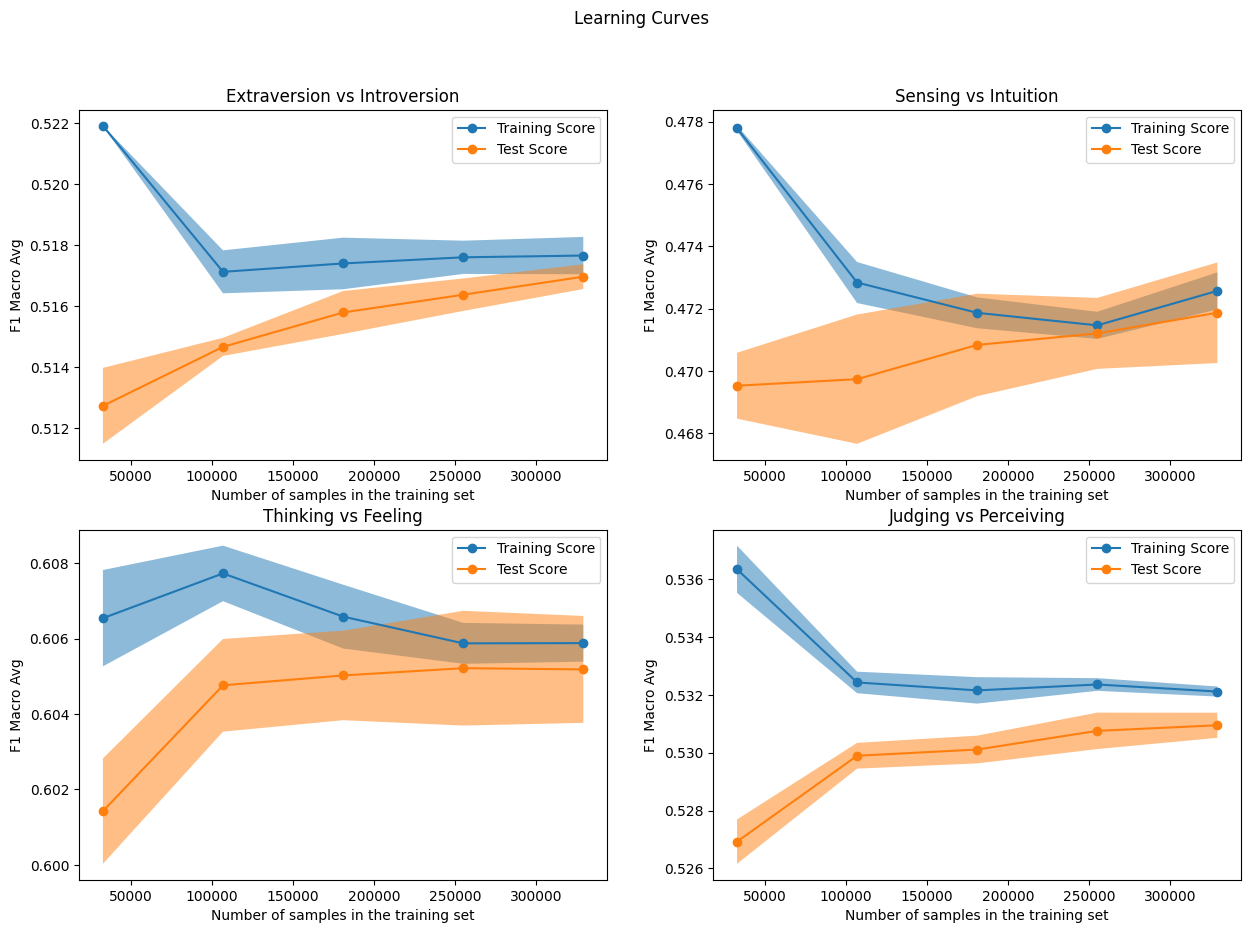

In [48]:
# Learning cruves for the classifiers.
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.flatten()

# Extraversion vs Introversion.
X_EI = np.concatenate((X_train_EI, X_test_EI), axis=0)
y_EI = np.concatenate((y_train_EI, y_test_EI), axis=0)
model0 = model_LR()
LearningCurveDisplay.from_estimator(model0, X_EI, y_EI, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[0])
handles0, label0 = ax[0].get_legend_handles_labels()
ax[0].legend(handles0[:2], ["Training Score", "Test Score"])
ax[0].set_title("Extraversion vs Introversion")

# Sensing vs Intuition.
X_SN = np.concatenate((X_train_SN, X_test_SN), axis=0)
y_SN = np.concatenate((y_train_SN, y_test_SN), axis=0)
model1 = model_LR()
LearningCurveDisplay.from_estimator(model1, X_SN, y_SN, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[1])
handles1, label1 = ax[1].get_legend_handles_labels()
ax[1].legend(handles1[:2], ["Training Score", "Test Score"])
ax[1].set_title("Sensing vs Intuition")

# Thinking vs Feeling.
X_TF = np.concatenate((X_train_TF, X_test_TF), axis=0)
y_TF = np.concatenate((y_train_TF, y_test_TF), axis=0)
model2 = model_LR()
LearningCurveDisplay.from_estimator(model2, X_TF, y_TF, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[2])
handles2, label2 = ax[2].get_legend_handles_labels()
ax[2].legend(handles2[:2], ["Training Score", "Test Score"])
ax[2].set_title("Thinking vs Feeling")

# Judging vs Perceiving.
X_JP = np.concatenate((X_train_JP, X_test_JP), axis=0)
y_JP = np.concatenate((y_train_JP, y_test_JP), axis=0)
model3 = model_LR()
LearningCurveDisplay.from_estimator(model3, X_JP, y_JP, scoring="f1_macro", score_name="F1 Macro Avg", score_type="both", n_jobs=4, line_kw={"marker": "o"}, random_state=42, ax=ax[3])
handles3, label3 = ax[3].get_legend_handles_labels()
ax[3].legend(handles3[:2], ["Training Score", "Test Score"])
ax[3].set_title("Judging vs Perceiving")

fig.suptitle("Learning Curves")
plt.show()